In [2]:
%%time

import os
import boto3
import re  # regular  expression  library 
import sagemaker
import sklearn
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Get a SageMaker-compatible role used by this Notebook Instance.
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### update below values appropriately ###
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-classification-diabete'
#### 

print(region)
print(bucket)

us-east-1
sagemaker-us-east-1-861737859161
CPU times: user 218 ms, sys: 24.1 ms, total: 242 ms
Wall time: 407 ms


In [3]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_BASE, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, 
               PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file_0 = open(DATA_DIR + "/" + FILE_TRAIN_0, 'w')
    train_file_1 = open(DATA_DIR + "/" + FILE_TRAIN_1, 'w')
    valid_file = open(DATA_DIR + "/" + FILE_VALIDATION, 'w')
    tests_file = open(DATA_DIR + "/" + FILE_TEST, 'w')

    num_of_data = len(data)
    num_train_0 = int((PERCENT_TRAIN_0/100.0)*num_of_data)
    num_train_1 = int((PERCENT_TRAIN_1/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train_0, num_train_1, num_valid, num_tests]
    split_data = [[],[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file_0.write(l)

    for l in split_data[1]:
        train_file_1.write(l)
        
    for l in split_data[2]:
        valid_file.write(l)

    for l in split_data[3]:
        tests_file.write(l)

    train_file_0.close()
    train_file_1.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.1 µs


In [4]:
%%time

from sklearn.datasets import load_svmlight_file

s3 = boto3.client("s3")

# Load the dataset
FILE_DATA_0RIG = 'diabete'

s3.download_file("sagemaker-sample-files-erasolon", f"datasets/classification/diabete.libsvm", FILE_DATA_0RIG)
data = load_svmlight_file(FILE_DATA_0RIG)

CPU times: user 184 ms, sys: 31 ms, total: 215 ms
Wall time: 735 ms


In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data[1])
labels = le.transform(data[1])

In [6]:
from sklearn.datasets import dump_svmlight_file

LABELED_FILE = FILE_DATA_0RIG +"_labeled.libsvm"

dump_svmlight_file(data[0], labels, LABELED_FILE)
s3.upload_file(LABELED_FILE, bucket , "datasets/classification/" + LABELED_FILE )

In [7]:
# Load the dataset
FILE_DATA = FILE_DATA_0RIG + '_labeled'
s3.download_file(bucket, "datasets/classification/" + LABELED_FILE, FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN_0 = FILE_DATA + '.train_0'
FILE_TRAIN_1 = FILE_DATA + '.train_1'
FILE_VALIDATION = FILE_DATA + '.validation'
FILE_TEST = FILE_DATA + '.test'
PERCENT_TRAIN_0 = 35
PERCENT_TRAIN_1 = 35
PERCENT_VALIDATION = 15
PERCENT_TEST = 15

DATA_DIR = 'data'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_0, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST)

In [8]:
#upload the files to the S3 bucket
upload_to_s3(bucket, 'train/train_0.libsvm', DATA_DIR + "/" + FILE_TRAIN_0)
upload_to_s3(bucket, 'train/train_1.libsvm', DATA_DIR + "/" + FILE_TRAIN_1)
upload_to_s3(bucket, 'validation/validation.libsvm', DATA_DIR + "/" + FILE_VALIDATION)
upload_to_s3(bucket, 'test/test.libsvm', DATA_DIR + "/" + FILE_TEST)

Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/train/train_0.libsvm/data/diabete_labeled.train_0
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/train/train_1.libsvm/data/diabete_labeled.train_1
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/validation/validation.libsvm/data/diabete_labeled.validation
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/test/test.libsvm/data/diabete_labeled.test


In [9]:
hyperparams = {
        "max_depth": "5",
        "num_class": len(le.classes_),
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "multi:softmax",
        "num_round": "50",
        "verbosity": "3",
        "eval_metric": "merror",
}

instance_type = "ml.m5.2xlarge"
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, FILE_DATA + '-dist-xgb')
content_type = "libsvm"

In [10]:
!pygmentize diabete.py

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb


def _xgb_train(params, dtrain, evals, num_boost_round, model_dir, is_master):
    """Run xgb train on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    booster = xgb.train(params=params,
                        dtrain=dtrain,
                        evals=evals,
                        num_boost_round=num_boost_round)

    if is_master:
        model_location = model_dir + '/xgboost-mo

In [11]:
# Open Source distributed script mode
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

boto_session = boto3.Session(region_name=region)
session = Session(boto_session=boto_session)
script_path = 'diabete.py'

xgb_script_mode_estimator = XGBoost(
    entry_point=script_path,
    framework_version='1.2-1', # Note: framework_version is mandatory
    hyperparameters=hyperparams,
    role=role,
    instance_count=2,
    instance_type=instance_type,
    output_path=output_path)

train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "validation"),content_type=content_type)

In [12]:
xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input})

2021-05-13 06:47:40 Starting - Starting the training job...
2021-05-13 06:48:03 Starting - Launching requested ML instancesProfilerReport-1620888459: InProgress
......
2021-05-13 06:49:03 Starting - Preparing the instances for training......
2021-05-13 06:50:04 Downloading - Downloading input data...
2021-05-13 06:50:33 Training - Downloading the training image...
2021-05-13 06:51:03 Training - Training image download completed. Training in progress.[2021-05-13 06:50:51.197 ip-10-0-125-14.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
[2021-05-13 06:50:55.046 ip-10-0-95-99.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-cont

In [13]:
predictor = xgb_script_mode_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.2xlarge")

-------------!

In [14]:
test_file = DATA_DIR + "/" + FILE_TEST
with open(test_file, 'r') as f:
    payload = f.read()

In [15]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)
response = runtime_client.invoke_endpoint(EndpointName=predictor.endpoint_name, 
                                          ContentType='text/libsvm', 
                                          Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted values are {}.'.format(result))

Predicted values are [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0].


In [16]:
y_pred = np.fromstring(result.replace("[","").replace("]",""), dtype=float, sep=',')

In [17]:
from sklearn.datasets import load_svmlight_file

data_true = load_svmlight_file(test_file)
y_true = data_true[1]

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65        37
         1.0       0.83      0.86      0.84        78

    accuracy                           0.78       115
   macro avg       0.75      0.74      0.75       115
weighted avg       0.78      0.78      0.78       115



In [19]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred)

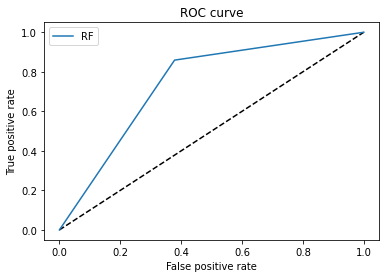

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
predictor.delete_endpoint()